<a href="https://colab.research.google.com/github/bluegenes/2019-burgers-shrooms/blob/master/biobombe_snakes/haptophyta_tybalt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run a Variational Autoencoder on MMETSP gene expression data

In [0]:
#colab setup: enable file downloads
from google.colab import files

## Download and Preprocess Haptophyta Data

In [0]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [0]:
random.seed(1234)

In [6]:
# Read in haptophyta mmetsp (orthogroup) count data
!wget https://osf.io/ek9nu/download -O haptophyta_orthogroup.quant.tsv
countfile = "haptophyta_orthogroup.quant.tsv"

--2019-11-03 18:53:02--  https://osf.io/ek9nu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/p4xvd/providers/osfstorage/5d8e3fd8d5512000195bf078?action=download&version=1&direct [following]
--2019-11-03 18:53:03--  https://files.osf.io/v1/resources/p4xvd/providers/osfstorage/5d8e3fd8d5512000195bf078?action=download&version=1&direct
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35522640 (34M) [application/octet-stream]
Saving to: ‘haptophyta_orthogroup.quant.tsv’

haptophyta_orthogro 100%[===================>]  33.88M  21.8MB/s    in 1.6s    

2019-11-03 18:53:05 (21.8 MB/s) - ‘haptophyta_orthogroup.quant.tsv’ saved [35522640/35522640]



In [7]:
# Read in count table (salmon TPM values)
og_count_data = pd.read_csv(countfile, dtype='str', sep='\t', index_col=0)
og_count_data.head()

,MMETSP0006,MMETSP0007,MMETSP0143,MMETSP0145,MMETSP0146,MMETSP0147,MMETSP0164,MMETSP0286,MMETSP0287,MMETSP0595,MMETSP0814,MMETSP0815,MMETSP0943,MMETSP0944,MMETSP0994,MMETSP0995,MMETSP0996,MMETSP0997,MMETSP1006,MMETSP1007,MMETSP1008,MMETSP1009,MMETSP1083,MMETSP1090,MMETSP1094,MMETSP1096,MMETSP1100,MMETSP1129,MMETSP1130,MMETSP1131,MMETSP1132,MMETSP1136,MMETSP1137,MMETSP1138,MMETSP1139,MMETSP1140,MMETSP1150,MMETSP1151,MMETSP1152,MMETSP1153,MMETSP1154,MMETSP1155,MMETSP1156,MMETSP1157,MMETSP1162,MMETSP1178,MMETSP1333,MMETSP1334,MMETSP1335,MMETSP1363,MMETSP1364,MMETSP1365,MMETSP1366,MMETSP1381,MMETSP1388,MMETSP1444,MMETSP1463,MMETSP1464,MMETSP1465,MMETSP1466,MMETSP1474
Orthogroup,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OG0000000,5.692404,9.192646,2.9055169999999997,3.757075,5.868158,5.499417,7.418778,3.367139,2.7031009999999998,7.326232000000001,8.386866,6.390308,7.671593,27.660133000000002,7.4820899999999995,19.202436,7.316675,4.081011,12.27723,12.057223,7.447748,15.5514,5.421988,50.268566,4.508126,2.790315,4.6651419999999995,25.560263,0,0,6.950589999999999,6.34561,4.817272,9.52047,10.384035,8.230353,6.275345,6.817439,8.036964999999999,6.022808,8.386174,2.755249,8.401511,13.666982,9.250552,6.69298,3.748318,3.84763,6.127899,5.304907,3.783507,6.547522,7.9800759999999995,11.982837,4.8169830000000005,3.247528,25.61122,24.079214,0,7.392098,7.807945
OG0000001,33.929821000000004,6.325476,2.18526,6.389158,78.751694,6.727567,0.0,4.448289,22.925297,10.532751,20.85804,14.984426999999998,3.861879,16.633406,6.413907,6.945968,2.9289669999999997,12.077438,13.40156,59.032679,174.72365200000002,21.920413,10.97166,29.78357,5.2642489999999995,12.900903999999999,9.61877,282.614685,0,14.749146,112.91372,17.807367000000003,6.834799,5.825709,9.662566,17.848036999999998,16.556667,9.07812,3.352292,8.404731,15.31913,12.016518,8.598666999999999,5.406474,27.223838,18.510285,6.404769,20.764166,36.026886,1.313285,5.7049129999999995,4.945348,46.201712,66.158688,8.142418,2.290923,15.398330999999999,5.742015,12.007027,42.200879,5.05271
OG0000002,324.253933,7.531185000000001,2.744903,4.242075,5.508942,3.0157689999999997,6.323272,6.7641350000000005,88.017239,10.547929,214.872567,9.040294,10.499975,9.936903,11.14763,100.072328,31.468903000000005,17.188476,9.319344000000001,15.127282999999998,270.45238,103.31606,16.923513,10.845783,5.004992,2.271213,6.452391,12.303547,0,32.078621000000005,8.721033,5.325386,6.3379129999999995,40.505463,114.866997,7.384146,11.045384,5.110608,3.859785,7.315498,16.532792999999998,6.760153,4.853857,7.419756,19.280310999999998,7.281847999999999,3.569462,17.38441,5.505254,8.671964,6.6644429999999995,32.506054999999996,6.080753,15.256177,8.955105999999999,6.568403999999999,47.265978999999994,8.417074000000001,18.271429,7.843901,3.130952
OG0000003,5.383275,11.367026,3.4986230000000003,4.546308,19.235832000000002,3.423806,6.057106,10.781557000000001,5.101061,15.737048000000001,11.805058,4.365718,18.657653,6.065597,7.1212,16.854955,13.258695999999999,9.310373,170.743919,16.255922,31.020125,29.343194,6.680433,7.117025999999999,5.444445,4.246262000000001,9.302824000000001,10.511528,0,0,9.42455,7.834925999999999,0,0,0,0,12.476213000000001,8.979183,9.513646000000001,15.553153,18.442789,12.229230000000001,5.601222,8.057167999999999,115.528158,5.869098999999999,6.142789,6.313898,0,6.417822,7.451776,3.065601,7.12507,0,8.484319000000001,6.745576,0,0,0,0,6.192581
OG0000004,30.886401,4.761553,2.954227,4.418489,4.029859,4.1453489999999995,4.741753,6.330821,3.734914,9.055886,21.724429,4.99175,16.284330999999998,27.424606,10.897036,8.573706,9.476449,11.537756,9.172114,5.986557,40.314775,11.516709,8.316373,14.105079000000002,6.336546,5.631332,4.631146,31.124793,0,0,4.525456,10.067772,0.0,12.401584,8.846511999999999,8.574632000000001,9.048193,10.22678,5.997726999999999,6.719832000000001,20.552970000000002,3.973926,1.545029,6.309607,4.844745,13.95246,5.3411610000000005,3.968332,5.101897,2.810343,3.720962,108.53154599999999,3.701343,0.378426

In [24]:
# Zero - One Normalize the data
min_max_scaler = MinMaxScaler()
og_count_data = og_count_data.sort_index() # sort by gene name
count_data_scaled = min_max_scaler.fit_transform(og_count_data.T)
data_DF = pd.DataFrame(count_data_scaled, index=og_count_data.columns, columns=og_count_data.index)  # transform back
print(min_max_scaler.data_max_)
print(data_DF.shape)
data_DF.head()

[ 50.268566 282.614685 324.253933 ...   7.271535   7.18217    4.199081]
(61, 181728)


Orthogroup,OG0000000,OG0000001,OG0000002,OG0000003,OG0000004,OG0000005,OG0000006,OG0000007,OG0000008,OG0000009,OG0000010,OG0000011,OG0000012,OG0000013,OG0000014,OG0000015,OG0000016,OG0000017,OG0000018,OG0000019,OG0000020,OG0000021,OG0000022,OG0000023,OG0000024,OG0000025,OG0000026,OG0000027,OG0000028,OG0000029,OG0000030,OG0000031,OG0000032,OG0000033,OG0000034,OG0000035,OG0000036,OG0000037,OG0000038,OG0000039,...,OG0181688,OG0181689,OG0181690,OG0181691,OG0181692,OG0181693,OG0181694,OG0181695,OG0181696,OG0181697,OG0181698,OG0181699,OG0181700,OG0181701,OG0181702,OG0181703,OG0181704,OG0181705,OG0181706,OG0181707,OG0181708,OG0181709,OG0181710,OG0181711,OG0181712,OG0181713,OG0181714,OG0181715,OG0181716,OG0181717,OG0181718,OG0181719,OG0181720,OG0181721,OG0181722,OG0181723,OG0181724,OG0181725,OG0181726,OG0181727
MMETSP0006,0.113240,0.120057,1.000000,0.031528,0.284585,0.372129,0.313386,0.285127,0.034639,0.127194,0.089839,0.084046,0.048706,0.131961,0.046643,0.269014,0.036366,0.011046,0.070939,0.005474,0.001700,0.340723,0.000000,0.333342,0.014974,0.175071,0.960524,0.001903,0.080592,0.056344,0.117644,0.361538,0.039543,0.099375,0.050278,0.078941,0.065393,0.047852,0.011632,0.076964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP0007,0.182871,0.022382,0.023226,0.066574,0.043873,0.377126,0.024101,0.096322,0.036715,0.259726,0.144828,0.102004,0.025812,1.000000,0.000000,0.454480,0.020584,0.001248,0.077553,0.016088,0.004223,0.402223,0.000000,0.000000,0.056349,0.215833,0.186821,0.002358,0.086602,0.066990,0.093418,0.162657,0.033529,0.339351,0.012331,0.054040,0.156668,0.000000,0.010513,0.143098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP0143,0.057800,0.007732,0.008465,0.020490,0.027220,0.185800,0.024457,0.212781,0.040922,0.021393,0.035259,0.183182,0.004641,0.129553,0.018143,0.094768,0.009886,0.022038,0.037027,0.004032,0.001375,0.032697,0.118859,0.174002,0.011624,0.046042,0.080552,0.002314,0.043051,0.032048,0.061299,0.011023,0.011835,0.133977,0.008052,0.026996,0.087583,0.034943,0.005934,0.062608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP0145,0.074740,0.022607,0.013083,0.026626,0.040712,0.640398,0.144029,0.116530,0.071693,0.046245,0.101445,0.112094,0.007620,0.123810,0.028936,0.327263,0.024654,0.012111,0.033370,0.028828,0.000665,0.090956,0.264583,0.335798,0.047425,0.097364,0.167749,0.001276,0.024647,0.095577,0.178292,0.045929,0.101011,0.183146,0.014000,0.034803,0.083895,0.056585,0.014289,0.076476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP0146,0.116736,0.278654,0.016990,0.112659,0.037131,0.743488,0.049232,0.108773,0.033942,0.036820,0.066114,0.101494,0.011029,0.143638,0.032650,0.222627,0.012764,0.039889,0.108565,0.019788,0.001843,0.056033,0.071793,0.560433,0.016368,0.072301,0.160783,0.001250,0.041747,0.053129,0.119692,0.022700,0.031716,0.132714,0.109678,0.020941,0.139898,0.048494,0.010253,0.085513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
## subset to top 8000 (or 5000) Median Absolute Deviation genes
num_mad_genes = 8000
mad_genes = data_DF.mad(axis=0).sort_values(ascending=False)
#mad_genes.head()
top_mad_genes = mad_genes.iloc[0:int(num_mad_genes), ].index
top_mad_genes

Index(['OG0026143', 'OG0014142', 'OG0014645', 'OG0025874', 'OG0010667',
       'OG0025586', 'OG0022720', 'OG0013874', 'OG0021190', 'OG0012010',
       ...
       'OG0034291', 'OG0013576', 'OG0030374', 'OG0025330', 'OG0008316',
       'OG0012183', 'OG0028580', 'OG0016459', 'OG0003419', 'OG0010882'],
      dtype='object', name='Orthogroup', length=8000)

In [27]:
mad_genes_df = data_DF.loc[:, top_mad_genes]
print(mad_genes_df.shape)
mad_genes_df.head()

(61, 8000)


Orthogroup,OG0026143,OG0014142,OG0014645,OG0025874,OG0010667,OG0025586,OG0022720,OG0013874,OG0021190,OG0012010,OG0020923,OG0019275,OG0023557,OG0018684,OG0011316,OG0031940,OG0018764,OG0013113,OG0022191,OG0028471,OG0002537,OG0030076,OG0009273,OG0025725,OG0031741,OG0015232,OG0013556,OG0021686,OG0026828,OG0010452,OG0025863,OG0013120,OG0018053,OG0020648,OG0013916,OG0003244,OG0008446,OG0008569,OG0002928,OG0014313,...,OG0021212,OG0008967,OG0017857,OG0016666,OG0019957,OG0038168,OG0013052,OG0002231,OG0017327,OG0032337,OG0011400,OG0006744,OG0002820,OG0031705,OG0024298,OG0043372,OG0030603,OG0013455,OG0010245,OG0013122,OG0032290,OG0023733,OG0018037,OG0026813,OG0012943,OG0030600,OG0020255,OG0022804,OG0012110,OG0018498,OG0034291,OG0013576,OG0030374,OG0025330,OG0008316,OG0012183,OG0028580,OG0016459,OG0003419,OG0010882
MMETSP0006,0.0,0.630037,0.000000,0.0,0.640573,0.0,0.0,0.000000,0.000000,0.533444,0.350737,0.497964,0.0,0.713517,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.530032,0.0,0.304823,0.0,0.0,0.0,0.0,0.0,0.000000,0.886682,0.0,0.000000,0.634326,0.0,0.0,0.671880,0.389809,0.0,0.385472,0.0,...,0.000000,0.440958,0.0,0.0,0.0,0.0,0.000000,0.292499,0.719749,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.761268,0.000000,0.586727,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.363783,0.0
MMETSP0007,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.358254,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.451201,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.389440,0.0
MMETSP0143,0.0,0.833012,0.221446,0.0,0.655937,0.0,0.0,0.370498,0.117383,0.000000,0.000000,0.186307,0.0,0.193336,0.342839,0.0,0.212954,0.775993,0.226872,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.363097,0.0,0.287991,0.000000,0.0,0.0,0.307059,0.000000,0.0,0.176353,0.0,...,0.397696,0.118063,0.0,0.0,0.0,0.0,0.339866,0.150212,0.241062,0.0,0.0,0.066797,0.151510,0.0,0.742984,0.0,0.0,0.140504,0.095442,0.257644,0.0,0.0,0.436470,0.298203,0.000000,0.0,0.0,0.0,0.219149,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.341213,0.634688,0.0
MMETSP0145,0.0,0.000000,0.000000,0.0,0.343745,0.0,0.0,0.661566,0.620570,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.463131,0.0,0.468869,0.0,0.0,0.0,0.0,0.0,0.215605,0.000000,0.0,0.000000,0.254476,0.0,0.0,0.823846,0.310678,0.0,0.715848,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.472938,0.585212,0.0,0.0,0.000000,0.214281,0.0,0.696247,0.0,0.0,0.000000,0.243755,0.000000,0.0,0.0,0.325491,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.188409,0.0,0.0,0.539445,0.000000,0.0
MMETSP0146,0.0,0.000000,0.000000,0.0,0.602343,0.0,0.0,0.324289,0.615060,0.000000,0.000000,0.544054,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.432626,0.0,0.326417,0.0,0.0,0.0,0.0,0.0,0.000000,0.498092,0.0,0.000000,0.000000,0.0,0.0,0.608175,0.000000,0.0,0.621023,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.373752,0.543819,0.778459,0.0,0.0,0.000000,0.289394,0.0,0.996410,0.0,0.0,0.648180,0.226347,0.000000,0.0,0.0,0.262909,0.000000,0.000000,0.0,0.0,0.0,0.164316,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [0]:
## Split test set - 10%, train set - 90%
percTest = 0.1
#full set of genes
skT_trainDF, skT_testDF =train_test_split(data_DF, test_size=percTest, random_state =42) #, shuffle=False
# top 8k median absolute deviation genes
mad_trainDF, mad_testDF =train_test_split(mad_genes_df, test_size=percTest, random_state =42) #, shuffle=False


In [29]:
print(skT_testDF.shape)
print(skT_trainDF.shape)
skT_trainDF.head()

(7, 181728)
(54, 181728)


Orthogroup,OG0000000,OG0000001,OG0000002,OG0000003,OG0000004,OG0000005,OG0000006,OG0000007,OG0000008,OG0000009,OG0000010,OG0000011,OG0000012,OG0000013,OG0000014,OG0000015,OG0000016,OG0000017,OG0000018,OG0000019,OG0000020,OG0000021,OG0000022,OG0000023,OG0000024,OG0000025,OG0000026,OG0000027,OG0000028,OG0000029,OG0000030,OG0000031,OG0000032,OG0000033,OG0000034,OG0000035,OG0000036,OG0000037,OG0000038,OG0000039,...,OG0181688,OG0181689,OG0181690,OG0181691,OG0181692,OG0181693,OG0181694,OG0181695,OG0181696,OG0181697,OG0181698,OG0181699,OG0181700,OG0181701,OG0181702,OG0181703,OG0181704,OG0181705,OG0181706,OG0181707,OG0181708,OG0181709,OG0181710,OG0181711,OG0181712,OG0181713,OG0181714,OG0181715,OG0181716,OG0181717,OG0181718,OG0181719,OG0181720,OG0181721,OG0181722,OG0181723,OG0181724,OG0181725,OG0181726,OG0181727
MMETSP1363,0.105531,0.004647,0.026744,0.037587,0.025894,0.193144,0.036431,0.088905,0.107158,0.032304,0.071800,0.047656,0.009873,0.113031,0.052038,0.409166,0.057134,0.054888,0.099443,0.012664,0.002470,0.079235,0.340454,0.231982,0.028871,0.334053,0.101107,0.000681,0.025918,0.044053,0.081219,0.026454,0.117256,0.195440,0.020647,0.099270,0.065601,0.061833,0.019957,0.199720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP0943,0.152612,0.013665,0.032382,0.109273,0.150042,0.494826,0.080819,0.100155,0.386652,0.155277,0.132225,0.159866,0.049703,0.187645,0.084694,0.250991,0.045268,0.012503,0.039843,0.007324,0.034988,0.353524,0.000000,0.412074,0.045624,0.201385,0.230532,0.000000,0.071107,0.054991,0.139860,0.020686,0.075953,0.436041,0.014616,0.086487,0.089402,0.114997,0.013952,0.085457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP1154,0.166827,0.054205,0.050987,0.108014,0.189373,0.347216,0.001141,0.000000,0.035333,0.175379,0.200702,0.608465,0.013685,0.225770,0.652421,0.272897,0.015397,0.006056,0.232923,0.025734,0.001705,0.096762,0.530626,0.204341,0.025162,0.052629,0.173212,0.000921,0.084133,0.055289,0.187435,0.065119,0.024916,0.140544,0.010320,0.108736,0.068458,0.174797,0.140198,0.115492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP1138,0.189392,0.020614,0.124919,0.000000,0.114267,0.000000,0.117144,0.172941,0.061474,0.083626,0.167704,0.065318,0.007608,0.210426,0.059800,0.248049,0.021488,0.049107,0.152367,0.012941,0.003761,0.100859,0.000000,0.269251,0.032258,0.129065,0.184520,0.002351,0.021080,0.071334,0.392396,0.015785,0.039156,0.232612,0.028965,0.025889,0.213203,0.072158,0.023471,0.157059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMETSP1466,0.147052,0.149323,0.024191,0.000000,0.000000,0.599671,0.028520,0.352907,0.064670,0.085597,0.070986,0.034400,0.022638,0.000000,0.039568,0.922877,0.022158,1.000000,0.082936,0.482387,0.002748,0.245243,0.207888,0.695015,0.054011,0.086581,0.163584,0.000000,0.024942,0.054104,0.229035,0.019146,0.000000,0.276732,0.021617,0.038418,0.323790,1.000000,0.045135,0.068794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print(mad_testDF.shape)
print(mad_trainDF.shape)
mad_trainDF.head()

(7, 8000)
(54, 8000)


Orthogroup,OG0026143,OG0014142,OG0014645,OG0025874,OG0010667,OG0025586,OG0022720,OG0013874,OG0021190,OG0012010,OG0020923,OG0019275,OG0023557,OG0018684,OG0011316,OG0031940,OG0018764,OG0013113,OG0022191,OG0028471,OG0002537,OG0030076,OG0009273,OG0025725,OG0031741,OG0015232,OG0013556,OG0021686,OG0026828,OG0010452,OG0025863,OG0013120,OG0018053,OG0020648,OG0013916,OG0003244,OG0008446,OG0008569,OG0002928,OG0014313,...,OG0021212,OG0008967,OG0017857,OG0016666,OG0019957,OG0038168,OG0013052,OG0002231,OG0017327,OG0032337,OG0011400,OG0006744,OG0002820,OG0031705,OG0024298,OG0043372,OG0030603,OG0013455,OG0010245,OG0013122,OG0032290,OG0023733,OG0018037,OG0026813,OG0012943,OG0030600,OG0020255,OG0022804,OG0012110,OG0018498,OG0034291,OG0013576,OG0030374,OG0025330,OG0008316,OG0012183,OG0028580,OG0016459,OG0003419,OG0010882
MMETSP1363,0.629901,0.000000,0.808261,0.496860,0.519696,0.899227,0.720944,0.668446,0.809559,0.510385,0.773305,1.0,0.630771,1.000000,0.595180,0.555962,0.985755,0.842217,0.573649,0.000000,0.000000,0.612851,0.687244,0.699412,0.760051,0.000000,0.459068,0.683409,0.746972,0.000000,0.764515,0.000000,0.000000,0.733001,0.458753,0.000000,0.794855,0.946007,0.786016,0.647588,...,0.303401,0.242236,0.653850,0.162292,0.355931,0.0,0.000000,0.210164,0.000000,0.321258,0.0,0.000000,0.303201,0.317389,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.416090,0.0,0.000000,0.400652,0.000000,0.263240,0.647547,0.364910,0.000000,0.000000,0.388304,0.0,0.618643,0.406344,0.000000,0.0,0.000000,0.059687,0.000000
MMETSP0943,0.000000,0.000000,0.976355,0.000000,0.874879,0.000000,0.000000,0.891786,0.000000,0.777477,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.914450,0.741369,0.000000,0.000000,0.000000,0.000000,0.785110,0.404028,0.000000,0.619163,0.824006,0.000000,0.844300,0.835465,0.000000,0.418471,0.000000,0.572401,0.802376,0.699590,0.000000,...,0.000000,0.364102,0.000000,0.000000,0.000000,0.0,0.000000,0.926966,0.591953,0.000000,0.0,1.000000,0.541511,0.000000,0.0,0.717103,0.000000,0.517265,0.000000,0.978160,0.0,0.000000,0.0,0.000000,0.471627,0.000000,0.797442,0.000000,0.000000,0.000000,0.000000,0.230822,0.0,0.000000,0.000000,0.000000,0.0,0.492474,0.383813,0.000000
MMETSP1154,1.000000,0.863102,0.700886,0.876149,0.752886,0.000000,0.698510,0.926866,0.824133,0.814948,0.859203,0.0,0.834887,0.620882,0.675862,0.814831,0.745490,0.695548,1.000000,0.987427,0.000000,1.000000,0.944491,0.804875,0.804660,0.994645,0.804752,0.949801,0.946411,0.000000,0.936345,0.856408,0.767265,0.744432,0.934238,0.710209,0.435944,0.648533,0.000000,0.647316,...,0.459410,0.000000,0.789509,0.399374,0.246698,0.0,0.373364,0.585990,0.000000,0.721825,0.0,0.196197,0.412586,0.000000,0.0,0.899693,0.993833,0.000000,0.280507,0.367266,1.0,0.835183,0.0,0.324981,0.423861,0.440126,0.265792,0.826931,0.558744,0.761217,0.814299,0.178691,0.0,0.285894,0.488267,0.315506,0.0,0.465668,0.566192,0.565308
MMETSP1138,0.000000,0.000000,0.930227,0.000000,0.960933,0.000000,0.000000,0.000000,0.000000,0.602385,0.000000,0.0,0.000000,0.745607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.326256,0.000000,0.000000,0.699487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.618478,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.666155,0.606918,0.000000,0.0,0.000000,0.000000,0.000000,0.251460,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.067604,0.000000
MMETSP1466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.505848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000

## Set Up Tybalt VAE

In [31]:
## based on VAE notebook (https://github.com/greenelab/tybalt/blob/master/tybalt_vae.ipynb)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [33]:
print(keras.__version__)
tf.__version__

2.2.5


'1.15.0'

In [32]:
# I want pretty progress bars in notebook during learning https://github.com/bstriner/keras-tqdm
! pip install keras-tqdm

In [0]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [0]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})


### Load Functions and Classes

This will facilitate connections between layers and also custom hyperparameters

In [0]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### Implementing Warm-up as described in Sonderby et al. LVAE

This is modified code from https://github.com/fchollet/keras/issues/2595

In [0]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [0]:
np.random.seed(123)

### Initialize variables and hyperparameters


In [0]:
# Set hyper parameters
#original_dim = data_DF.shape[1]
original_dim = mad_genes_df.shape[1]
latent_dim = 100

batch_size =  5 #50
epochs = 100 #50
learning_rate = 0.0015

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

### Encoder 

In [0]:
# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

### Decoder

In [0]:
# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

### Connect the encoder and decoder to make the VAE

The CustomVariationalLayer() includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

The VAE is compiled with an Adam optimizer and built-in custom loss function. The loss_weights parameter ensures beta is updated at each epoch end callback

In [50]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 8000)         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          800100      input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          800100      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 100)          400         dense_4[0][0]                    
____________________________________________________________________________________________

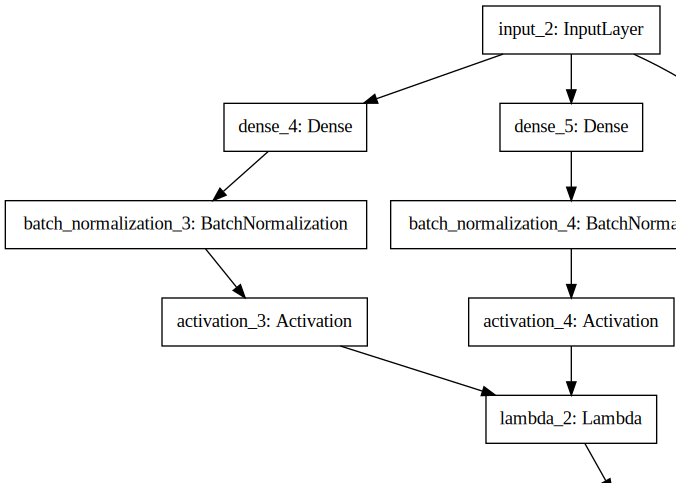

In [51]:
# Visualize the connections of the custom VAE model
output_model_file = 'onehidden_vae_architecture.png' #os.path.join('figures', 'onehidden_vae_architecture.png')
plot_model(vae, to_file=output_model_file)

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### Train the model
The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [52]:
## Run MAD genes only model

%%time 
hist = vae.fit(np.array(mad_trainDF),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(mad_testDF), None),
               callbacks=[WarmUpCallback(beta, kappa),
               TQDMNotebookCallback(leave_inner=True, leave_outer=True)])


CPU times: user 1min 11s, sys: 2.94 s, total: 1min 14s
Wall time: 46.8 s


In [0]:
# to run full model, need to change initial params (original_dim) to use full data_DF
#hist_full = vae.fit(np.array(skT_trainDF),
#               shuffle=True,
#               epochs=epochs,
#               verbose=0,
#               batch_size=batch_size,
#               validation_data=(np.array(skT_testDF), None),
#               callbacks=[WarmUpCallback(beta, kappa),
#                          TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

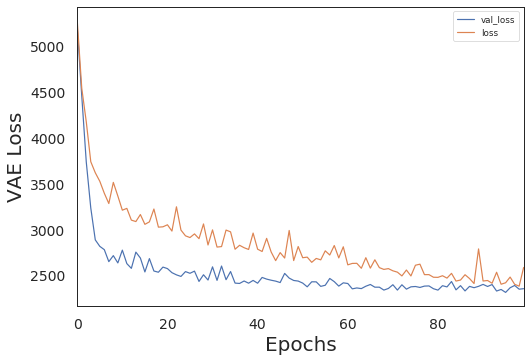

In [53]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = 'onehidden_vae_training.pdf' #os.path.join('figures', 'onehidden_vae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

# Compile and output trained models
We are interested in:

 - The model to encode/compress the input gene expression data
   - Can be possibly used to compress other tumors
 - The model to decode/decompress the latent space back into gene expression space
   - This is our generative model
 - The latent space compression of all pan cancer TCGA samples
   - Non-linear reduced dimension representation of tumors can be used as features for various tasks
     - Supervised learning tasks predicting specific gene inactivation events
     - Interpolating across this space to observe how gene expression changes between two cancer states
 - The weights used to compress each latent node
   - Potentially indicate learned biology differentially activating tumors

##### Encoder model

In [0]:
# Model to compress input
encoder = Model(rnaseq_input, z_mean_encoded)

In [0]:
# Encode rnaseq into the hidden/latent representation - and save output
#encoded_rnaseq_df = encoder.predict_on_batch(data_DF)
encoded_rnaseq_df = encoder.predict_on_batch(mad_genes_df)

#encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=data_DF.index)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=mad_genes_df.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1
encoded_file = 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv' #os.path.join('data', 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv')
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

## Decoder (generative) model


In [0]:

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

## Save the encoder/decoder models for future investigation


In [0]:
!mkdir -p models
encoder_model_file = os.path.join('models', 'encoder_onehidden_vae.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

## Model Interpretation - Sanity Check
### Observe the distribution of node activations.
We want to ensure that the model is learning a distribution of feature activations, and not zeroing out features.

In [58]:
# What are the most and least activated nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

sample_id
70    81.955162
83    81.315865
63    76.070358
50    71.959961
53    71.899345
81    71.332886
4     71.052406
55    70.594772
86    69.196533
88    68.269035
dtype: float32


sample_id
97     49.158356
68     48.850334
35     48.833267
85     48.607578
74     48.485241
77     48.141960
49     47.820267
79     47.809254
100    47.795940
82     46.341671
dtype: float32

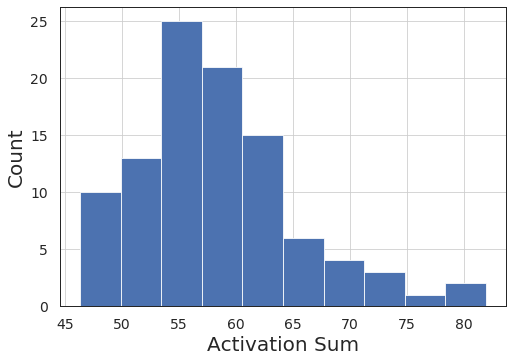

In [59]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');  

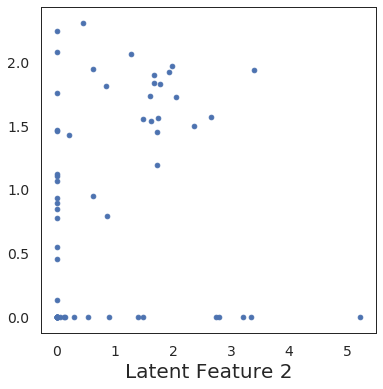

In [60]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 1], encoded_rnaseq_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.xlabel('Latent Feature 2');

### Observe reconstruction fidelity


In [73]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(encoded_rnaseq_df))
#input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=data_DF.index,
                                        #columns=data_DF.columns)
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=mad_genes_df.index,
                                        columns=mad_genes_df.columns)                                       # columns=dataT_normalized_DF.columns)
input_rnaseq_reconstruct.head(2)

Orthogroup,OG0026143,OG0014142,OG0014645,OG0025874,OG0010667,OG0025586,OG0022720,OG0013874,OG0021190,OG0012010,OG0020923,OG0019275,OG0023557,OG0018684,OG0011316,OG0031940,OG0018764,OG0013113,OG0022191,OG0028471,OG0002537,OG0030076,OG0009273,OG0025725,OG0031741,OG0015232,OG0013556,OG0021686,OG0026828,OG0010452,OG0025863,OG0013120,OG0018053,OG0020648,OG0013916,OG0003244,OG0008446,OG0008569,OG0002928,OG0014313,...,OG0021212,OG0008967,OG0017857,OG0016666,OG0019957,OG0038168,OG0013052,OG0002231,OG0017327,OG0032337,OG0011400,OG0006744,OG0002820,OG0031705,OG0024298,OG0043372,OG0030603,OG0013455,OG0010245,OG0013122,OG0032290,OG0023733,OG0018037,OG0026813,OG0012943,OG0030600,OG0020255,OG0022804,OG0012110,OG0018498,OG0034291,OG0013576,OG0030374,OG0025330,OG0008316,OG0012183,OG0028580,OG0016459,OG0003419,OG0010882
MMETSP0006,0.005429,0.571018,0.128733,0.004963,0.429263,0.011888,0.005137,0.228889,0.029578,0.338197,0.021415,0.369022,0.005405,0.320624,0.071215,0.003306,0.121802,0.029188,0.025221,0.006163,0.259468,0.002911,0.134112,0.012085,0.007894,0.010238,0.039964,0.005042,0.007467,0.637798,0.003794,0.105018,0.554816,0.004385,0.027614,0.705104,0.268504,0.099163,0.281607,0.022796,...,0.055042,0.169999,0.006569,0.011606,0.027049,0.018158,0.021769,0.184599,0.087031,0.006224,0.004663,0.136396,0.287887,0.013701,0.162394,0.087715,0.006265,0.141925,0.101555,0.037100,0.004617,0.012669,0.846293,0.011596,0.100173,0.026509,0.080715,0.003972,0.043398,0.006813,0.024086,0.026376,0.003897,0.012332,0.118479,0.019628,0.047571,0.033486,0.287626,0.021896
MMETSP0007,0.002233,0.111963,0.022190,0.001317,0.243452,0.006072,0.002950,0.071358,0.015063,0.045607,0.008809,0.079667,0.001683,0.114788,0.012403,0.000713,0.011828,0.009474,0.007588,0.000707,0.047734,0.000616,0.039366,0.005377,0.001711,0.001864,0.018140,0.001824,0.000987,0.296980,0.000796,0.012735,0.196907,0.001886,0.004839,0.541817,0.041175,0.014372,0.091025,0.007483,...,0.018021,0.075238,0.002313,0.005606,0.014306,0.004514,0.006783,0.070237,0.006135,0.001178,0.001609,0.031256,0.151452,0.003474,0.069038,0.011522,0.001474,0.097908,0.093057,0.020212,0.001055,0.003550,0.610031,0.002962,0.023549,0.007102,0.035906,0.000692,0.037265,0.002485,0.009243,0.004655,0.000806,0.002991,0.076888,0.009305,0.016161,0.006182,0.197547,0.005057


In [74]:
#reconstruction_fidelity = data_DF - input_rnaseq_reconstruct
reconstruction_fidelity = mad_genes_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
#gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(data_DF.shape[0])
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(mad_genes_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
Orthogroup,,
OG0011054,-0.046938,0.195623
OG0001946,-0.004829,0.186831
OG0008085,0.005282,0.182729
OG0006838,0.007808,0.179202
OG0009770,0.011445,0.178499


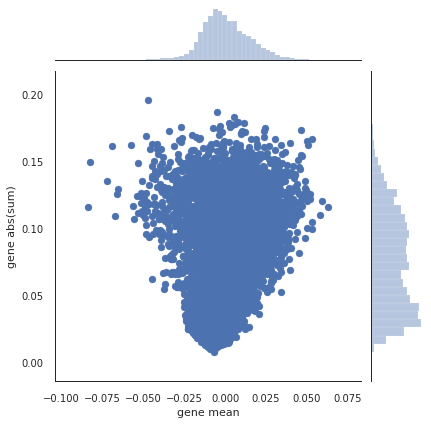

In [75]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary, stat_func=None);

### Interpret the results

#### Extract Tybalt Weights

In [0]:
## Now let's try to interpret:
#https://github.com/greenelab/tybalt/blob/master/extract_tybalt_weights.ipynb

In [0]:
import os
import pandas as pd
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set(style='white', color_codes=True)
sns.set_context('paper', rc={'font.size':8, 'axes.titlesize':10, 'axes.labelsize':15})

In [0]:
%matplotlib inline
plt.style.use('seaborn-notebook')


Because of the complex architecture involved in encoding the data, we will use the decoded weights to describe feature encoding specific activation patterns

In [67]:
# Load the decoder model
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')
decoder = load_model(decoder_model_file)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [68]:
# Load RNAseq file
#rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv.gz')
#rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
#rnaseq_df = data_DF
rnaseq_df = mad_genes_df
rnaseq_df.head(2)

Orthogroup,OG0026143,OG0014142,OG0014645,OG0025874,OG0010667,OG0025586,OG0022720,OG0013874,OG0021190,OG0012010,OG0020923,OG0019275,OG0023557,OG0018684,OG0011316,OG0031940,OG0018764,OG0013113,OG0022191,OG0028471,OG0002537,OG0030076,OG0009273,OG0025725,OG0031741,OG0015232,OG0013556,OG0021686,OG0026828,OG0010452,OG0025863,OG0013120,OG0018053,OG0020648,OG0013916,OG0003244,OG0008446,OG0008569,OG0002928,OG0014313,...,OG0021212,OG0008967,OG0017857,OG0016666,OG0019957,OG0038168,OG0013052,OG0002231,OG0017327,OG0032337,OG0011400,OG0006744,OG0002820,OG0031705,OG0024298,OG0043372,OG0030603,OG0013455,OG0010245,OG0013122,OG0032290,OG0023733,OG0018037,OG0026813,OG0012943,OG0030600,OG0020255,OG0022804,OG0012110,OG0018498,OG0034291,OG0013576,OG0030374,OG0025330,OG0008316,OG0012183,OG0028580,OG0016459,OG0003419,OG0010882
MMETSP0006,0.0,0.630037,0.0,0.0,0.640573,0.0,0.0,0.0,0.0,0.533444,0.350737,0.497964,0.0,0.713517,0.0,0.0,0.0,0.0,0.0,0.0,0.530032,0.0,0.304823,0.0,0.0,0.0,0.0,0.0,0.0,0.886682,0.0,0.0,0.634326,0.0,0.0,0.67188,0.389809,0.0,0.385472,0.0,...,0.0,0.440958,0.0,0.0,0.0,0.0,0.0,0.292499,0.719749,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761268,0.0,0.586727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363783,0.0
MMETSP0007,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,1.00000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.358254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.451201,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.389440,0.0


In [0]:
# For a future pathway analysis, the background genes are important
# Also needed to set column names on weights
!mkdir -p data
background_file = os.path.join('data', 'background_genes.txt')
background_genes = pd.DataFrame(rnaseq_df.columns)
background_genes.to_csv(background_file, index=False, header=False, sep='\t')

### Extracting example patterns learned by Tybalt

#### Extract Tybalt weight matrix and write to file


In [70]:
# Extract the weights from the decoder model
weights = []
for layer in decoder.layers:
    weights.append(layer.get_weights())
    
weight_layer_df = pd.DataFrame(weights[1][0], columns=rnaseq_df.columns, index=range(1, 101))
weight_layer_df.index.name = 'encodings'
print(weight_layer_df.shape)
weight_layer_df.head(2)

(100, 8000)


Orthogroup,OG0026143,OG0014142,OG0014645,OG0025874,OG0010667,OG0025586,OG0022720,OG0013874,OG0021190,OG0012010,OG0020923,OG0019275,OG0023557,OG0018684,OG0011316,OG0031940,OG0018764,OG0013113,OG0022191,OG0028471,OG0002537,OG0030076,OG0009273,OG0025725,OG0031741,OG0015232,OG0013556,OG0021686,OG0026828,OG0010452,OG0025863,OG0013120,OG0018053,OG0020648,OG0013916,OG0003244,OG0008446,OG0008569,OG0002928,OG0014313,...,OG0021212,OG0008967,OG0017857,OG0016666,OG0019957,OG0038168,OG0013052,OG0002231,OG0017327,OG0032337,OG0011400,OG0006744,OG0002820,OG0031705,OG0024298,OG0043372,OG0030603,OG0013455,OG0010245,OG0013122,OG0032290,OG0023733,OG0018037,OG0026813,OG0012943,OG0030600,OG0020255,OG0022804,OG0012110,OG0018498,OG0034291,OG0013576,OG0030374,OG0025330,OG0008316,OG0012183,OG0028580,OG0016459,OG0003419,OG0010882
encodings,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.032892,0.111381,0.016390,0.023570,0.009940,-0.099993,-0.036612,0.046998,-0.009904,0.069173,-0.032273,-0.004207,-0.038286,0.046667,0.044044,-0.022224,-0.014099,-0.003282,-0.022521,0.071086,0.027083,-0.061695,0.037524,-0.043347,-0.078073,0.028898,-0.034891,-0.005175,0.046676,-0.011255,0.001048,0.018971,0.064282,-0.074129,0.010055,0.098511,0.060231,0.023966,0.090988,-0.019136,...,-0.053321,-0.07286,0.000631,-0.015204,-0.036109,-0.011840,0.003965,0.007190,-0.045680,-0.059327,-0.008339,0.031199,-0.026910,-0.028522,-0.025114,0.102194,-0.035236,-0.092205,-0.027950,0.028618,0.004781,-0.007184,0.053650,-0.010828,0.090145,0.001020,0.014910,-0.021805,-0.017545,0.002871,-0.039347,-0.066507,-0.067692,-0.052563,-0.075472,-0.038467,-0.059160,0.001425,-0.046177,0.046017
2,-0.010868,-0.033040,-0.107052,-0.045788,-0.033962,0.051586,0.023247,-0.051109,-0.085512,-0.101788,0.087226,0.038187,0.008713,-0.017832,-0.110357,-0.093914,-0.104888,-0.027006,0.026712,-0.132427,-0.015357,-0.103524,-0.044682,0.072599,-0.073412,-0.092313,-0.024977,-0.060256,-0.036908,-0.028444,-0.069166,0.002849,-0.152481,-0.001570,-0.036395,-0.046423,0.035849,-0.119098,-0.117181,-0.035440,...,0.009209,0.01511,0.116860,0.076665,-0.033852,-0.022635,-0.053722,0.078845,0.002069,-0.053160,0.045278,-0.122678,0.036793,0.009158,-0.061320,-0.086785,0.051010,-0.016900,0.047809,-0.090075,0.025364,-0.020040,-0.087704,-0.106804,-0.146299,0.025067,-0.028805,-0.061333,-0.008360,0.018424,-0.019262,-0.011462,-0.120987,-0.106412,0.000017,-0.034599,0.037397,-0.051316,-0.060606,0.020967


In [0]:
# Write the genes to file
!mkdir -p results
#weight_file = os.path.join('results', 'tybalt_gene_weights.tsv')
weight_file = os.path.join('results', 'tybalt_mad_gene_weights.tsv')
weight_layer_df.to_csv(weight_file, sep='\t')

In [0]:
files.download(os.path.join('results', 'tybalt_mad_gene_weights.tsv')) 

In [76]:
encoding_genes = weight_layer_df.T
#encoding_genes.head()
print(encoding_genes.shape)

(8000, 100)


#### Look at the most active nodes

In [80]:
#### Okay let's look at the most active nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)
# Top 10 most active nodes
print(sum_node_activity.head(10))
#top_node = sum_node_activity

sample_id
70    81.955162
83    81.315865
63    76.070358
50    71.959961
53    71.899345
81    71.332886
4     71.052406
55    70.594772
86    69.196533
88    68.269035
dtype: float32
(8000, 1)


,encoding 70
Orthogroup,
OG0051156,0.376828
OG0051193,0.366834
OG0047854,-0.329677
OG0020270,-0.328733
OG0047029,0.321268


In [0]:
def output_high_weight_genes(weight_df, encoding, filename, thresh=2.5):
    """
    Function to process and output high weight genes given specific feature encodings
    """
    
    # Sort initial encoding by absolute activation
    encoding_df = (
        weight_df
        .reindex(weight_df[encoding].abs()
                 .sort_values(ascending=False).index)[encoding]
    )
    
    hw_pos_cutoff = encoding_df.mean() + (encoding_df.std() * thresh)
    hw_pos_df = pd.DataFrame(encoding_df[encoding_df > hw_pos_cutoff])
    hw_pos_df = hw_pos_df.assign(direction='positive')
    
    hw_neg_cutoff = encoding_df.mean() - (encoding_df.std() * thresh)
    hw_neg_df = pd.DataFrame(encoding_df[encoding_df < hw_neg_cutoff])
    hw_neg_df = hw_neg_df.assign(direction='negative')

    hw_df = pd.concat([hw_pos_df, hw_neg_df])
    hw_df.index.name = 'genes'
    hw_df.to_csv(filename, sep='\t')
    return hw_df

In [83]:
# Encoding 70
node_70 = weight_layer_df.loc[[70], :].T
node_70.head()
node_70.columns = ['encoding 70']
node_70 = (node_70.reindex(node_70['encoding 70'].abs().sort_values(ascending=False).index))
print(node_70.shape)
node_70.head()

(8000, 1)


,encoding 70
Orthogroup,
OG0051156,0.376828
OG0051193,0.366834
OG0047854,-0.329677
OG0020270,-0.328733
OG0047029,0.321268


In [84]:
# Encoding 70 to file
hw_node70_file = os.path.join('results', 'high_weight_genes_node70_skcm.tsv')
node70_df = output_high_weight_genes(node_70, 'encoding 70', hw_node70_file)
node70_df.head(5)

,encoding 70,direction
genes,,
OG0051156,0.376828,positive
OG0051193,0.366834,positive
OG0047029,0.321268,positive
OG0051366,0.287070,positive
OG0046809,0.280716,positive


In [0]:
files.download(hw_node70_file) 


In [89]:
## output the high weight genes explaining each tail of each node for some top nodes
node_83 = weight_layer_df.loc[[83], :].T
node_83.columns = ['encoding 83']
node_83 = (node_83.reindex(node_83['encoding 83'].abs().sort_values(ascending=False).index))
print(node_83.shape)
hw_node83_file = os.path.join('results', 'high_weight_genes_node83_skcm.tsv')
node83_df = output_high_weight_genes(node_83, 'encoding 83', hw_node83_file)
node83_df.head(5)

node_63 = weight_layer_df.loc[[63], :].T
node_63.columns = ['encoding 63']
node_63 = (node_63.reindex(node_63['encoding 63'].abs().sort_values(ascending=False).index))
print(node_63.shape)
hw_node63_file = os.path.join('results', 'high_weight_genes_node63_skcm.tsv')
node63_df = output_high_weight_genes(node_63, 'encoding 63', hw_node63_file)
node63_df.head(5)

#files.download(hw_node83_file) 
#files.download(hw_node63_file) 

(8000, 1)
(8000, 1)


,encoding 63,direction
genes,,
OG0046848,0.269559,positive
OG0041493,0.259700,positive
OG0043258,0.256350,positive
OG0030551,0.255434,positive
OG0041762,0.247326,positive


# Exploring High Weight Genes

https://github.com/greenelab/tybalt/blob/master/high_weight_genes.ipynb

Visualizing the distribution of high weight genes across different dimensionality reduction algorithms, including PCA, ICA, NMF, ADAGE, and Tybalt. The standard procedure for defining high weight genes is defined by greater than 2.5 standard deviations away from the mean, separately for both positive and negative tails.

The module high_weight_genes facilitates high weight gene discovery using different metrics defined at custom thresholds.

### Interpretation
Methods like ICA and ADAGE learn features that have more even tailed distributions and are less skewed than methods like PCA, NMF, and Tybalt. Defining high weight genes using NMF can only be done using positive tails, whereas ADAGE and ICA learn different representations in each tail. The neural network based approaches ADAGE and Tybalt (and other VAE variants), and to a lesser extent ICA, learn different types of distributions in each node. The distributions they learn have different skew and kurtosis. These observations necesitate a dynamic procedure of assigning genes to nodes.

In the following notebook we explore the distributions of high weight genes across features learned by the aformentioned algorithms.

#### 1) High weight positive and negative genes defined by standard protocol
First, we visualize the distribution of high weight genes for positive and negative tails within a single node for each algorithm. We determine that some methods (ADAGE) have largely symmetrical nodes, while others (Tybalt and VAE variants) have some nodes with many genes isolated in only one of the tails.

#### 2) Diversity of individual node distributions
Next, we plot the full distribution of the first 25 features (of 100) defined for each algorithm. From this analysis it is clear the features for each algorithm learn quite different distributions. ADAGE learn gene weights near zero with light tails, NMF learn only positive weights, and VAE variants, PCA, and ICA learn heterogeneous feature distributions.

#### 3) Skewness and Kurtosis
We observe the distribution of skewness and kurtosis for each feature across algorithms. This analysis will give us a clearer picture on feature heterogeneity and how defining high weight genes across algorithms may be artificially penalized by standard methods. We observe increased node distribution heterogeneity for VAE variants, NMF, but less heterogeneity for PCA, ICA, and ADAGE features.

#### 4) Node Type Designations
Lastly, we determine that a dynamic procedure for assigning high weight genes to nodes may be helpful in assigning biological patterns to learned features. We define node types as:

  - **Type A:** Low skewness, low kurtosis
These are the nodes closest to normal distributions
More stringent cutoffs required to eliminate false postive genes (use > 3 standard deviations)
  - **Type B:** Low skewness, high kurtosis
Symmetrical distributions but many genes at the end of tails.
Use the standard procedure for defining high weight genes (> 2.5 standard deviations)
  - **Type C:** High skewness, low kurtosis
Heavily biased toward postive high weight or negative high weight genes, but few activated genes
Type C nodes can be split into two types Type C Pos and Type C Neg, designated based on if they include more positive high weight genes or negative high weight genes.
Use standard procedure for defining high weight in long tails, but strict procedure for defining opposite tail.
  - **Type D:** High skewness, high kurtosis
Heavily biased toward one tail, with many activated genes
Type D nodes can also be split into two types depending on direction of the high weight tail
Use the opposite high weight gene procedure however to reduce false positive but still capture some signal in the opposite high weight tail.

We apply the correction and visualize the adjusted distributions. A pathway coverage analysis will determine if these adjustments improve pathway discovery.

In [91]:
! pip install git+git://github.com/greenelab/tybalt.git

  Cloning git://github.com/greenelab/tybalt.git to /tmp/pip-req-build-rhsw9ecz
  Running command git clone -q git://github.com/greenelab/tybalt.git /tmp/pip-req-build-rhsw9ecz
  Created wheel for tybalt: filename=tybalt-0.0.0-cp36-none-any.whl size=19053 sha256=b8e578d1f012983c793dcbe992d792d71b22e2dcb0f9ef177f9ababaa8b83053
  Stored in directory: /tmp/pip-ephem-wheel-cache-4savr1ii/wheels/e2/3f/29/28ffc21ee6794aa0535f03ab3934adfc5d7ba1e6e715c9cb2b
Successfully built tybalt


In [0]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from tybalt.genes import high_weight_genes

In [0]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [0]:
sns.set(style='white', color_codes=True)
sns.set_context('paper', rc={'font.size':14, 'axes.titlesize':20, 'axes.labelsize':16})

In [0]:
# High weight gene metrics
metric = 'stddev'
threshold = 2.5

# Color dictionary
algorithm_color_dict = {'ADAGE': '#33a02c',
                        'Tybalt': '#fb9a99'}

In [0]:
# Feature file locations
#tybalt_file = os.path.join('results', 'tybalt_gene_weights.tsv')
tybalt_file = os.path.join('results', 'tybalt_mad_gene_weights.tsv')

In [0]:
# Instantiate high weight gene objects
tybalt_weights = high_weight_genes(tybalt_file, metric=metric, thresh=threshold, algorithm='Tybalt')

### Visualize distributions
Certain high_weight_genes methods enable quick visualizations of high weigh gene features. Here, we show:

 1. Positive and negative tail number of high weight genes
 2. Full gene activity distributions

We use the standard method of extracting high weight genes as presented in Tan et al. 2017. Briefly, this method calculates the standard deviation of the gene weight distribution and then selects high weight genes based on a cutoff: abs(weight) > 2.5 stddev

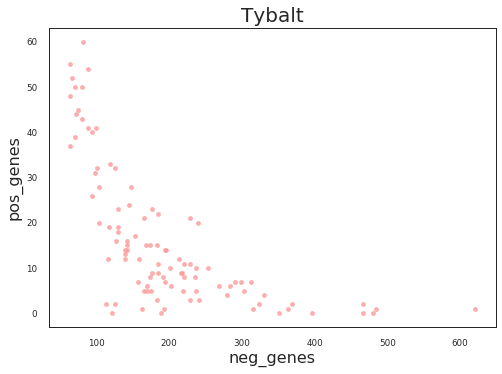

In [98]:
#### Positive/negative tails
tybalt_weights.count_high_weight_genes(return_plot=True, title='Tybalt',
                                       color=algorithm_color_dict['Tybalt']);

#### Full gene activities

Plot full gene activities for the first 10 encodings

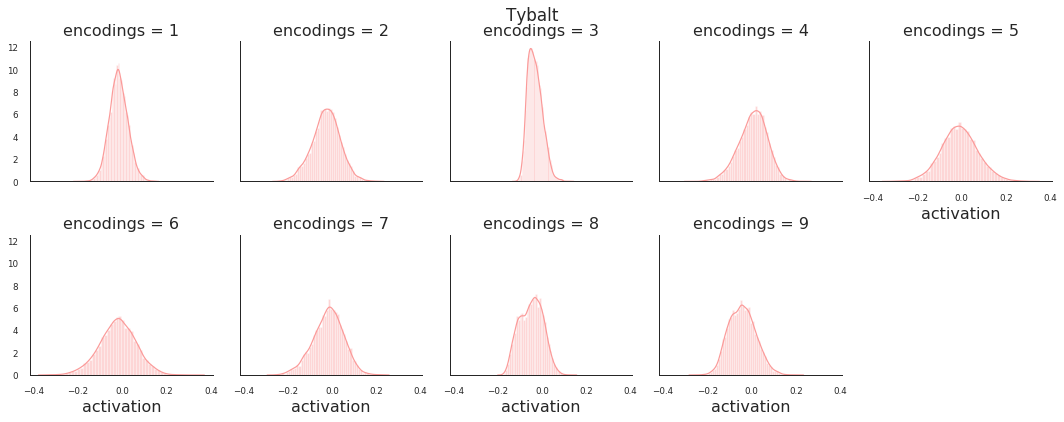

In [107]:
first_encodings = range(1, 10)
tybalt_weights.plot_weight_dist(features=first_encodings, title='Tybalt',
                                color=algorithm_color_dict['Tybalt']);

### Observe distribution of skewness and kurtosis

 - Skewness - measure of distribution symmetry (normal distribution = 0)
 - Kurtosis - measure of tail density (light tail is < 0, heavy tail is > 0)

We also remove outliers in this visualization to focus on the areas of highest densities. The outliers are defined based on calculating z-scores for skew and kurtosis and discarding the feature if it is > 3z for either. We output the nodes of interest with their corresponding values. The distributions of the samples over these features can be explored in our Shiny App.

Empty DataFrame
Columns: [skew, kurtosis]
Index: []


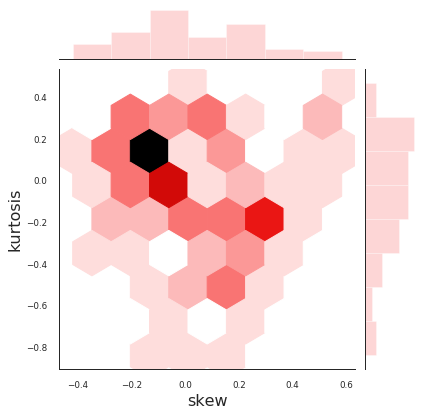

In [101]:
tybalt_node_categories = tybalt_weights.get_node_categories(melted=True)
ax, tybalt_outlier = tybalt_weights.plot_skewkurtosis(color=algorithm_color_dict['Tybalt'])
print(tybalt_outlier)


### Define Node Categories based on Feature Activation Distributions
Skew	
Kurtosis		Low	High
Low	Type A	Type C
High	Type B	Type D


We also define subsets of Type C and Type D nodes because the skew could be positive (left tail) or negative (right tail).

High Skewness and Kurtosis determined statistically significantly different than normal using scipy.stats.skewtest and scipy.stats.kurtosistest with a Bonferroni adjusted p value.

#### Adjust for node type distributions and reassign high weights

The adjustments are made based on skewness and kurtosis observations for each node. Specially, each node is assigned a type and the high weight gene cutoff is modified based on the node type.

 - **Type A** nodes have low skew and kurtosis.
  - This means gene features are symmetrical and include few genes in tails.
  - Increase the threshold by 0.5 to remove false positive genes from selection.
 - **Type B** nodes have low skew and high kurtosis.
  - This means gene features are symmetrical and include many genes in tails.
  - This is the standard distribution designed for the given input threshold.
 - **Type C** nodes have high skew and low kurtosis.
  - This means gene features are not symmetrical and include few genes in tails.
  - A single standard deviation cutoff is inappropriate to capture genes in both the positive and negative tails.
  - If the distribution is right skewed (more genes in the left tail), use the standard approach to identify left tailed genes, but increase the threshold by 0.5 to remove false positive genes from right tails.
  - If the distribution is left skewed (more genes in the right tail), use the standard approach to identify right tailed genes, but increase the threshold by 0.5 to remove false positive genes from the left tails.
 - **Type D** nodes have high skew and high kurtosis.
  - This means gene features are not symmetrical and include many genes in tails.
  - A single standard deviation cutoff is inappropriate to capture genes in both the positive and negative tails.
  - If the distribution is right skewed (more genes in the left tail), decrease the threshold by 0.5 to identify left tailed genes, and use the standard threshold to identify genes from the right tails.
  - If the distribution is left skewed (more genes in the right tail), decrease the threshold by 0.5 to identify right tailed genes, and use the standard threshold to identify genes from the left tails.

### TSNE

https://github.com/greenelab/tybalt/blob/master/tsne_tybalt_features.ipynb


In [103]:
#encoded_file = os.path.join('data', 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv')
encoded_file = 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv' #os.path.join('data', 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv')

encoded_df = pd.read_table(encoded_file, index_col=0)
encoded_df.head(2)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
MMETSP0006,1.876448,0.000000,0.894085,0.0,0.000000,0.000000,0.0,1.842967,0.000000,0.949929,0.000000,1.103950,0.197296,1.363058,1.941934,0.178247,0.0,1.806945,1.911012,2.329956,1.419165,1.427361,0.000000,0.000000,0.0,1.333015,0.587078,0.000000,0.000000,1.050492,1.732553,1.238803,0.000000,1.802754,0.000000,2.228982,0.000000,1.679959,0.384220,1.933236,...,1.272338,0.000000,0.000000,1.792688,0.00000,0.419507,1.919660,1.008051,1.427680,0.0,1.422614,2.229233,2.323743,0.0,0.097729,1.302169,0.348179,0.068128,1.834200,0.000000,0.0,0.000000,0.409598,1.339217,0.000000,0.002742,0.732180,0.0,1.848647,2.360391,0.232767,0.000000,1.971651,0.709128,2.104425,1.936856,1.084748,0.288469,2.605636,0.000000
MMETSP0007,1.611497,1.601281,1.729570,0.0,1.685952,0.745061,0.0,1.490728,0.821921,1.718158,1.611425,1.850023,0.922934,1.577315,1.880125,0.000000,0.0,1.628002,1.636423,1.803375,1.812692,1.466057,0.340933,1.574398,0.0,1.319699,1.868377,0.241569,1.404316,1.688224,1.846892,2.457212,0.553136,1.545540,1.339619,2.165811,1.111624,1.998572,1.858137,1.949196,...,1.090916,1.970214,0.688201,1.632058,1.76517,0.000000,2.105552,1.565908,1.627673,0.0,1.495416,0.969223,2.277291,0.0,0.218676,1.780312,2.004975,2.764904,2.015788,1.186617,0.0,0.556212,1.257863,1.868572,0.299366,0.000000,2.734659,0.0,2.617791,2.287021,0.825425,0.150838,1.999727,1.383164,2.026740,2.213120,0.324772,0.925415,2.184832,1.443945


In [104]:
# Load Zero-One transformed (min-max scaled) RNAseq data
#rnaseq_df = data_DF
rnaseq_df= mad_genes_df
 #os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv.gz')
#rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(61, 8000)


Orthogroup,OG0026143,OG0014142,OG0014645,OG0025874,OG0010667,OG0025586,OG0022720,OG0013874,OG0021190,OG0012010,OG0020923,OG0019275,OG0023557,OG0018684,OG0011316,OG0031940,OG0018764,OG0013113,OG0022191,OG0028471,OG0002537,OG0030076,OG0009273,OG0025725,OG0031741,OG0015232,OG0013556,OG0021686,OG0026828,OG0010452,OG0025863,OG0013120,OG0018053,OG0020648,OG0013916,OG0003244,OG0008446,OG0008569,OG0002928,OG0014313,...,OG0021212,OG0008967,OG0017857,OG0016666,OG0019957,OG0038168,OG0013052,OG0002231,OG0017327,OG0032337,OG0011400,OG0006744,OG0002820,OG0031705,OG0024298,OG0043372,OG0030603,OG0013455,OG0010245,OG0013122,OG0032290,OG0023733,OG0018037,OG0026813,OG0012943,OG0030600,OG0020255,OG0022804,OG0012110,OG0018498,OG0034291,OG0013576,OG0030374,OG0025330,OG0008316,OG0012183,OG0028580,OG0016459,OG0003419,OG0010882
MMETSP0006,0.0,0.630037,0.0,0.0,0.640573,0.0,0.0,0.0,0.0,0.533444,0.350737,0.497964,0.0,0.713517,0.0,0.0,0.0,0.0,0.0,0.0,0.530032,0.0,0.304823,0.0,0.0,0.0,0.0,0.0,0.0,0.886682,0.0,0.0,0.634326,0.0,0.0,0.67188,0.389809,0.0,0.385472,0.0,...,0.0,0.440958,0.0,0.0,0.0,0.0,0.0,0.292499,0.719749,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761268,0.0,0.586727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363783,0.0
MMETSP0007,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,1.00000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.358254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.451201,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.389440,0.0


In [105]:
# Perform t-SNE on VAE encoded_features
import pandas as pd
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
tsne_out = tsne.fit_transform(encoded_df)
tsne_out = pd.DataFrame(tsne_out, columns=['1', '2'])
tsne_out.index = encoded_df.index
tsne_out.index.name = 'tcga_id'
tsne_out_file = os.path.join('results', 'tybalt_tsne_features.tsv')
tsne_out.to_csv(tsne_out_file, sep='\t')
tsne_out.head(2)

#sns.lmplot(x="1", y="2", data=tsne_out, fit_reg=False, legend=True, size=9) # hue='txga_id')


,1,2
tcga_id,,
MMETSP0006,-73.798187,71.180283
MMETSP0007,-128.354691,111.290894


In [106]:
# Perform t-SNE on zero-one RNAseq features
tsne_rna = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                         learning_rate=300, n_iter=400)
tsne_rna_out = tsne_rna.fit_transform(rnaseq_df)
tsne_rna_out = pd.DataFrame(tsne_rna_out, columns=['1', '2'])
tsne_rna_out.index = rnaseq_df.index
tsne_rna_out.index.name = 'tcga_id'
tsne_rna_out_file = os.path.join('results', 'rnaseq_tsne_features.tsv')
tsne_rna_out.to_csv(tsne_rna_out_file, sep='\t')
tsne_rna_out.head(2)

#sns.lmplot(x="1", y="2", data=tsne_rna_out, fit_reg=False, legend=True, size=9) # hue='txga_id')


,1,2
tcga_id,,
MMETSP0006,-90.218323,-124.422630
MMETSP0007,4.323671,29.967873
